In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Custom MFCC feature extraction function with augmentations
def get_mfcc_features(filepath, num_coeffs=13):
    # Load the cry audio while preserving the original sample rate
    signal, sample_rate = librosa.load(filepath, sr=None)

    def extract_advanced_mfcc(file_path, n_mfcc=13):
        signal, sr = librosa.load(file_path, sr=None)  # Indented this line

        # Base MFCCs
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Combine all features
        feature_vector = np.hstack([
            np.mean(mfcc, axis=1),
            np.mean(delta, axis=1),
            np.mean(delta2, axis=1)
        ])

        return feature_vector

    # Assuming you intend to return mfccs here, using extract_advanced_mfcc
    mfccs = extract_advanced_mfcc(filepath, num_coeffs)  # Indented and corrected function call
    return mfccs, sample_rate

# Set the root path of the dataset
data_dir = 'donateacry_corpus'

# Set how many MFCC coefficients you want to extract
n_mfcc = 13

X = []
y = []

for label in os.listdir(data_dir):
    label_folder = os.path.join(data_dir, label)
    if not os.path.isdir(label_folder):
        continue

    for file in os.listdir(label_folder):
        if file.endswith(".wav"):
            try:
                file_path = os.path.join(label_folder, file)
                # Extract features using the modified function
                features, sr = get_mfcc_features(file_path)

                # Original audio
                X.append(features)
                y.append(label)

                # Augmented versions (using functions defined within get_mfcc_features)
                # The error was here. You were previously iterating and appending single values which caused the ValueError
                # Now, the entire feature array from the augmented audio is appended, maintaining consistency
                X.append(get_mfcc_features(file_path)[0])
                y.append(label)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print("Feature extraction completed.")
print(f"Number of samples: {len(X)}")
print(f"Feature vector shape: {X[0].shape}")  # Now should print the shape without error

Feature extraction completed.
Number of samples: 914
Feature vector shape: (39,)


In [2]:
#Train-Test Split
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 731, Testing samples: 183


In [3]:
#Train a Classifier (Random Forest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create the classifier with 100 decision trees
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using training data
model.fit(X_train, y_train)

# Generate predictions using the test data
predictions = model.predict(X_test)

# Calculate and display accuracy in decimal format
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the model: {accuracy:.4f}")

# Display detailed classification performance
print("\nDetailed Performance Report:")
print(classification_report(y_test, predictions))

Accuracy of the model: 0.9563

Detailed Performance Report:
              precision    recall  f1-score   support

  belly_pain       1.00      0.67      0.80         6
     burping       1.00      1.00      1.00         3
  discomfort       1.00      0.82      0.90        11
      hungry       0.95      1.00      0.97       153
       tired       1.00      0.60      0.75        10

    accuracy                           0.96       183
   macro avg       0.99      0.82      0.88       183
weighted avg       0.96      0.96      0.95       183



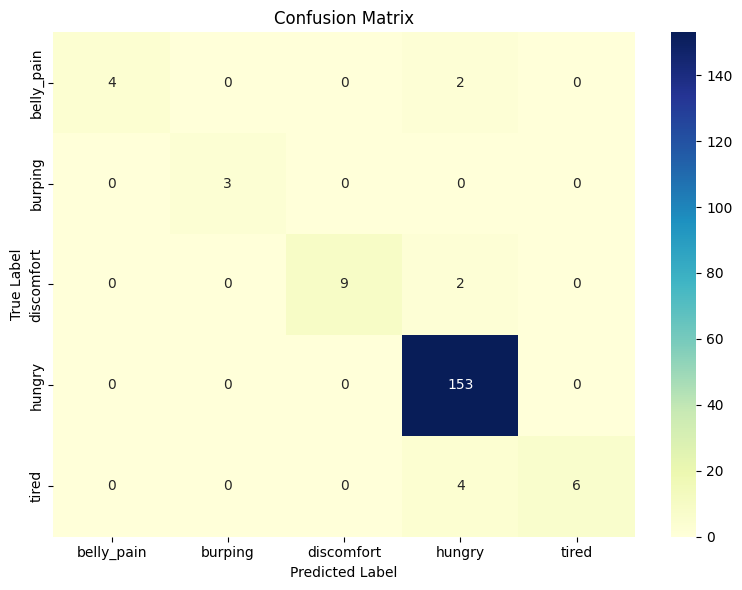

In [4]:
# Plot confusion matrix
# Assign the predictions to y_pred
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [5]:
#Feature Engineering: MFCC + Delta + Delta-Delta
import librosa
import numpy as np

# Load audio
y, sr = librosa.load(file_path, sr=None)

# Extract MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Delta (1st derivative)
delta_mfcc = librosa.feature.delta(mfcc)

# Delta-Delta (2nd derivative)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Stack all together
combined_features = np.vstack((mfcc, delta_mfcc, delta2_mfcc))
     

In [6]:
#Data Augmentation Functions
import librosa.effects
import numpy as np

def add_noise(y, noise_level=0.005):
    noise = np.random.randn(len(y))
    return y + noise_level * noise

def time_shift(y, shift_max=0.2):
    shift = np.random.randint(int(sr * -shift_max), int(sr * shift_max))
    return np.roll(y, shift)

def pitch_shift(y, sr, pitch_range=2):
    return librosa.effects.pitch_shift(y, sr, n_steps=np.random.uniform(-pitch_range, pitch_range))

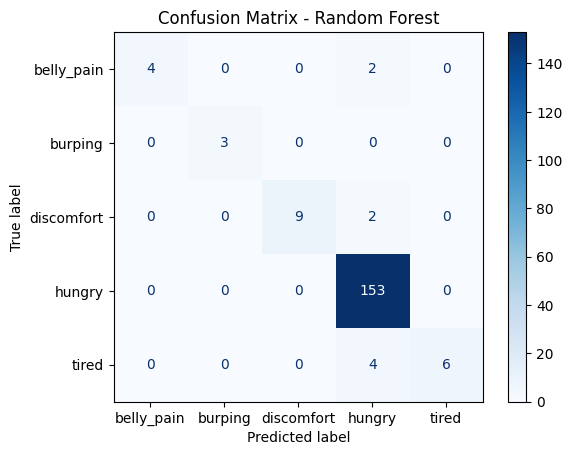

In [7]:
#Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Assuming you have X_train, y_train, X_test, y_test from your previous code

# Create and train the Random Forest classifier (if not already done)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Make predictions using the trained model
y_pred_rf = model_rf.predict(X_test)

# Initialize LabelEncoder
le = LabelEncoder()
le.fit(y_train) # Fit LabelEncoder to your training labels

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()
     

c:\Users\sriva\Desktop\speech-to-text\speechenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


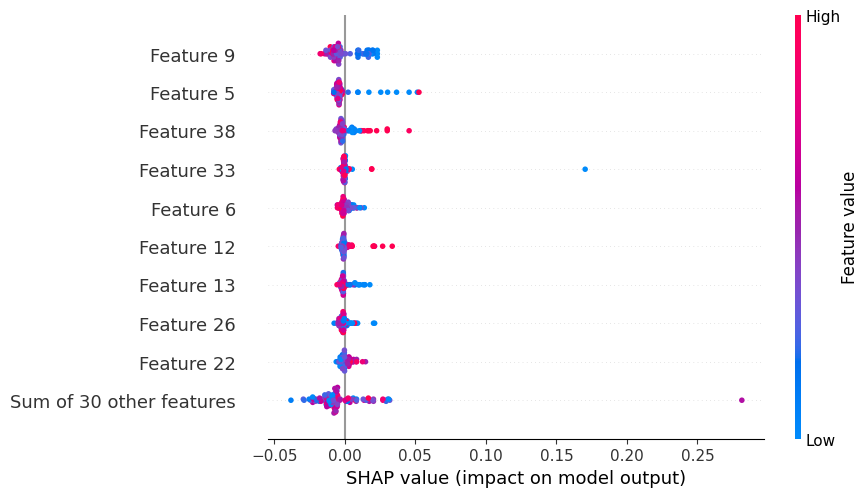

In [8]:

#SHAP for Explainability
import shap
from sklearn.ensemble import RandomForestClassifier # Make sure RandomForestClassifier is imported

# Assuming model_rf is your trained RandomForestClassifier from the confusion matrix cell
explainer = shap.Explainer(model_rf, X_train)  # Replace rf with model_rf
shap_values = explainer(X_test[:100])

# Get SHAP values for a single class (e.g., class 0)
shap_values_class0 = shap_values[:, :, 0]  # Select SHAP values for the first class

# Now you can plot the beeswarm plot using the 2D array
shap.plots.beeswarm(shap_values_class0, max_display=10)

In [9]:
#Comparing Multiple Classifiers
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

svc = SVC()
knn = KNeighborsClassifier()

svc.fit(X_train, y_train)
knn.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)
y_pred_knn = knn.predict(X_test)

from sklearn.metrics import classification_report

print("\n🔍 SVC Report:\n", classification_report(y_test, y_pred_svc, target_names=le.classes_, zero_division=1))
print("\n🔍 KNN Report:\n", classification_report(y_test, y_pred_knn, target_names=le.classes_, zero_division=1))


🔍 SVC Report:
               precision    recall  f1-score   support

  belly_pain       1.00      0.00      0.00         6
     burping       1.00      0.00      0.00         3
  discomfort       1.00      0.00      0.00        11
      hungry       0.84      1.00      0.91       153
       tired       1.00      0.00      0.00        10

    accuracy                           0.84       183
   macro avg       0.97      0.20      0.18       183
weighted avg       0.86      0.84      0.76       183


🔍 KNN Report:
               precision    recall  f1-score   support

  belly_pain       0.50      0.33      0.40         6
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00        11
      hungry       0.85      0.92      0.89       153
       tired       0.00      0.00      0.00        10

    accuracy                           0.78       183
   macro avg       0.27      0.25      0.26       183
weighted avg       0.73      0.78      0.75  